In [7]:
import os, sys
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

sys.path.append('../modules')
from ar_scale import calc_ar_scale

In [2]:
def read_mesowest_prec_data(filename):
    df = pd.read_csv(filename, header=6, skiprows=[7], sep=',', engine='python',
                              parse_dates=['Date_Time'])
    # Converting the index as date (need to do this to utilize functionality of resample)
    df.index = pd.to_datetime(df.Date_Time)
    
    ## Precip from gauges is in precipitation accumulation (inch) in one hour, measured every ~5 min
    # Need to convert to precip accumulated (mm) each minute measured each x minutes
    # divide by 60 (minutes in an hour) and multiply by x minutes (delta time (mins) between t-1 and t)
    
    df['precip_accum_one_hour_set_1'].fillna(0) # fill nans with 0
    df['delta'] = (df['Date_Time']-df['Date_Time'].shift()).fillna(pd.Timedelta('0 minutes')) # calculate the difference between the time steps
    df['ans'] = df['delta'].apply(lambda x: x  / np.timedelta64(1,'m')).astype('int64') # calculate the difference between the time steps
    df['prec_hrly'] = ((df.precip_accum_one_hour_set_1/60.0)*df.ans) # divide by 60 (to covert to minutes) and multiple by delta minutes
    tmp = df['prec_hrly'].resample('1H').sum()

    return tmp

In [3]:
def create_data_for_plots(d):
    '''
    Author: Deanna Nash (dnash@ucsd.edu)
    Parameters: 
        d: dictionary with lat, lon of grid cell, start_date and end_date of AR event
    
    Returns:
        df: a pandas dataframe with columns "water_year" and "AR_scale"
        df_case: a pandas dataframe with columns "IVT" for the duration of the event and dates as the index
        df_arscale: a pandas dataframe with column "AR_scale", "start_date", and "end_date"
        sublist: list of values of percentile thresholds, ordered according to perc_lbl lst
        perc_lbl: list of percent values that correspond with the sublist thresholds
    '''
    ## pull info from dict
    lat = d['lat']
    lon = d['lon']
    sdate = d['sdate']
    edate = d['edate']
    
    ## read dataset with IVT values
    fname = '../out/IVT_ERA5_{0}N_{1}W.csv'.format(lat, lon*-1)
    df = pd.read_csv(fname)
    df = df.set_index(pd.to_datetime(df.time))
    df = df.drop(['time'], axis=1)
    df = df.reset_index()
    df = df.rename(columns={"time": "date"})
    
    ## compute percentile thresholds on entire period of record
    perc = [0.5, 0.75, 0.95]
    perc_lbl = ['50%', '75%', '95%']
    sublist = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
            sublist.append(df['IVT'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    
    ## calc ar scale
    ar_scale = calc_ar_scale(df)
    
    ## add month from start_date column
    ar_scale = ar_scale.set_index(pd.to_datetime(ar_scale.start_date))
    ## add water year to data as coordinate
    water_year = (ar_scale.index.month >= 10) + ar_scale.index.year
    month = ar_scale.index.month
    ar_scale['water_year'] = water_year
    ar_scale['month'] = month
    
    ## clean up dataframe for plotting
    tmp = ar_scale.drop(['start_date', 'end_date', 'duration', 'max_IVT', 'month'], axis=1)
    tmp = tmp.reset_index()
    tmp = tmp.drop(['start_date'], axis=1)
    tmp["YR"] = pd.to_datetime(tmp.water_year, format="%Y").dt.strftime('%y')
    
    df = df.set_index(pd.to_datetime(df.date))
    idx = (df.index >= sdate) & (df.index <= edate)
    df_case = df.loc[idx]
    df_case = df_case.drop('date', axis=1)
    
    # case = case.rename(columns={"time": "date"})
    df_arscale = calc_ar_scale(df_case.reset_index())
    return tmp, df_case, df_arscale, sublist
    
def plot_historical_ar_scale_frequency(ax, df, titlestring):
    '''
    Author: Deanna Nash (dnash@ucsd.edu)
    Parameters: 
        ax: empty gridspec axes to plot the data on
        df: a pandas dataframe with columns "water_year" and "AR_scale"
    
    Returns:
        ax: gridspec axes with bar plot showing the frequency of AR events each water year colored by AR scale
    '''

    colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
    g = df.groupby(['YR', 'AR_scale']).size().unstack().plot(kind='bar', stacked=True, legend=False,
                                                             rot='horizontal', color=colors, ax=ax)

    ax.set_yticks(np.arange(0, 20, 5))
    ax.set_ylim(0, 20)
    plt.xlabel("Water Year (YY)")
    
    for label in g.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    ax.text(0.025, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)


    return ax

def plot_IVT_time_series_AR_scale(ax, df_case, df_arscale, sublist, landslide_time, titlestring):
    '''
    Author: Deanna Nash (dnash@ucsd.edu)
    Parameters: 
        ax: empty gridspec axes to plot the data on
        df_case: a pandas dataframe with columns "IVT" for the duration of the event and dates as the index
        df_arscale: a pandas dataframe with column "AR_scale", "start_date", and "end_date"
        sublist: list of values of percentile thresholds, ordered according to perc_lbl lst
        perc_lbl: list of percent values that correspond with the sublist thresholds
    
    Returns:
        ax: gridspec axes with bar plot showing the frequency of AR events each water year colored by AR scale
    '''
    ### Get x-tick and x-labels for both cases
    x1 = df_case.index.values

    ### Plot the IVT time series
    ax.plot(x1, df_case.IVT.values, color='k')
    ax.set_xlim(x1.min(), x1.max())
    
    ## x-axis format dates/ticks
    days = mdates.DayLocator(interval=1)   # every day
    hours = mdates.HourLocator(interval=2)  # every 2-hour
    dayhr_fmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(dayhr_fmt)
    ax.xaxis.set_minor_locator(hours)

    ax.set_yticks(np.arange(0, 1000, 250))
    ax.set_ylim(0, 750)
    
    # highlight a time range if there is AR scale value
    for index, row in df_arscale.iterrows():
        if row['AR_scale'] == 1:
            c = (10./255.0, 193./255.0, 255./255.0) #10, 193, 255
        elif row['AR_scale'] == 2:
            c = (4./255.0, 255./255.0, 3./255.0) #4, 255, 3
        elif row['AR_scale'] == 3:
            c = (255./255.0, 255./255.0, 3./255.0) #255, 255, 3
        elif row['AR_scale'] == 4:
            c = (255./255.0, 166./255.0, 2./255.0) #255, 166, 2
        elif row['AR_scale'] == 5:
            c = (255./255.0, 1./255.0, 0./255.0) #255, 1, 0
        ax.axvspan(row['start_date'], row['end_date'], color=c, alpha=0.7)
    
    ## add percentile thresholds
    perc_lbl = ['50th', '75th', '95th']
    style = {'size': 7, 'color': 'black', 'fontweight': 'normal'}
    lstyle_lst = ['dotted', 'dashed', 'dotted']
    for i, sub in enumerate(sublist):
        ax.axhline(y=sub[0], color='grey', lw=0.5, linestyle=lstyle_lst[i])
    
        ax.annotate(perc_lbl[i], xy=(x1[5], sub[0]), xycoords='data',
                        textcoords="offset points", # how to position the text
                        xytext=(0,-3), # distance from text to points (x,y)
                        bbox=dict(boxstyle="square,pad=0.1", fc="white", ec=None, lw=0.0),
                        **style)

    ## add timing of landslide
    plt.axvline(x = pd.to_datetime(landslide_time), color ='red')

    ax.text(0.025, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    return ax

def plot_image(ax, fname, titlestring):
    image=mpimg.imread(fname)
    ax.imshow(image)
    cur_axes = plt.gca()
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.text(0.025, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    return ax

In [4]:
## case study dict
d = {"wrangell": {"lat": 56.5,
                  "lon": -132.5,
                  "sdate": '2023-11-16 18',
                  "edate": '2023-11-22 18',
                  "landslide_time": '2023-11-21 06:30'},
     "haines":   {"lat": 59.0,
                  "lon": -135.5,
                  "sdate": '2020-11-27 18',
                  "edate": '2020-12-03 18',
                  "landslide_time": '2020-12-02 10:17'}}

# get information for plot
df1, df_case1, df_arscale1, sublist1 = create_data_for_plots(d['haines'])
df2, df_case2, df_arscale2, sublist2 = create_data_for_plots(d['wrangell'])

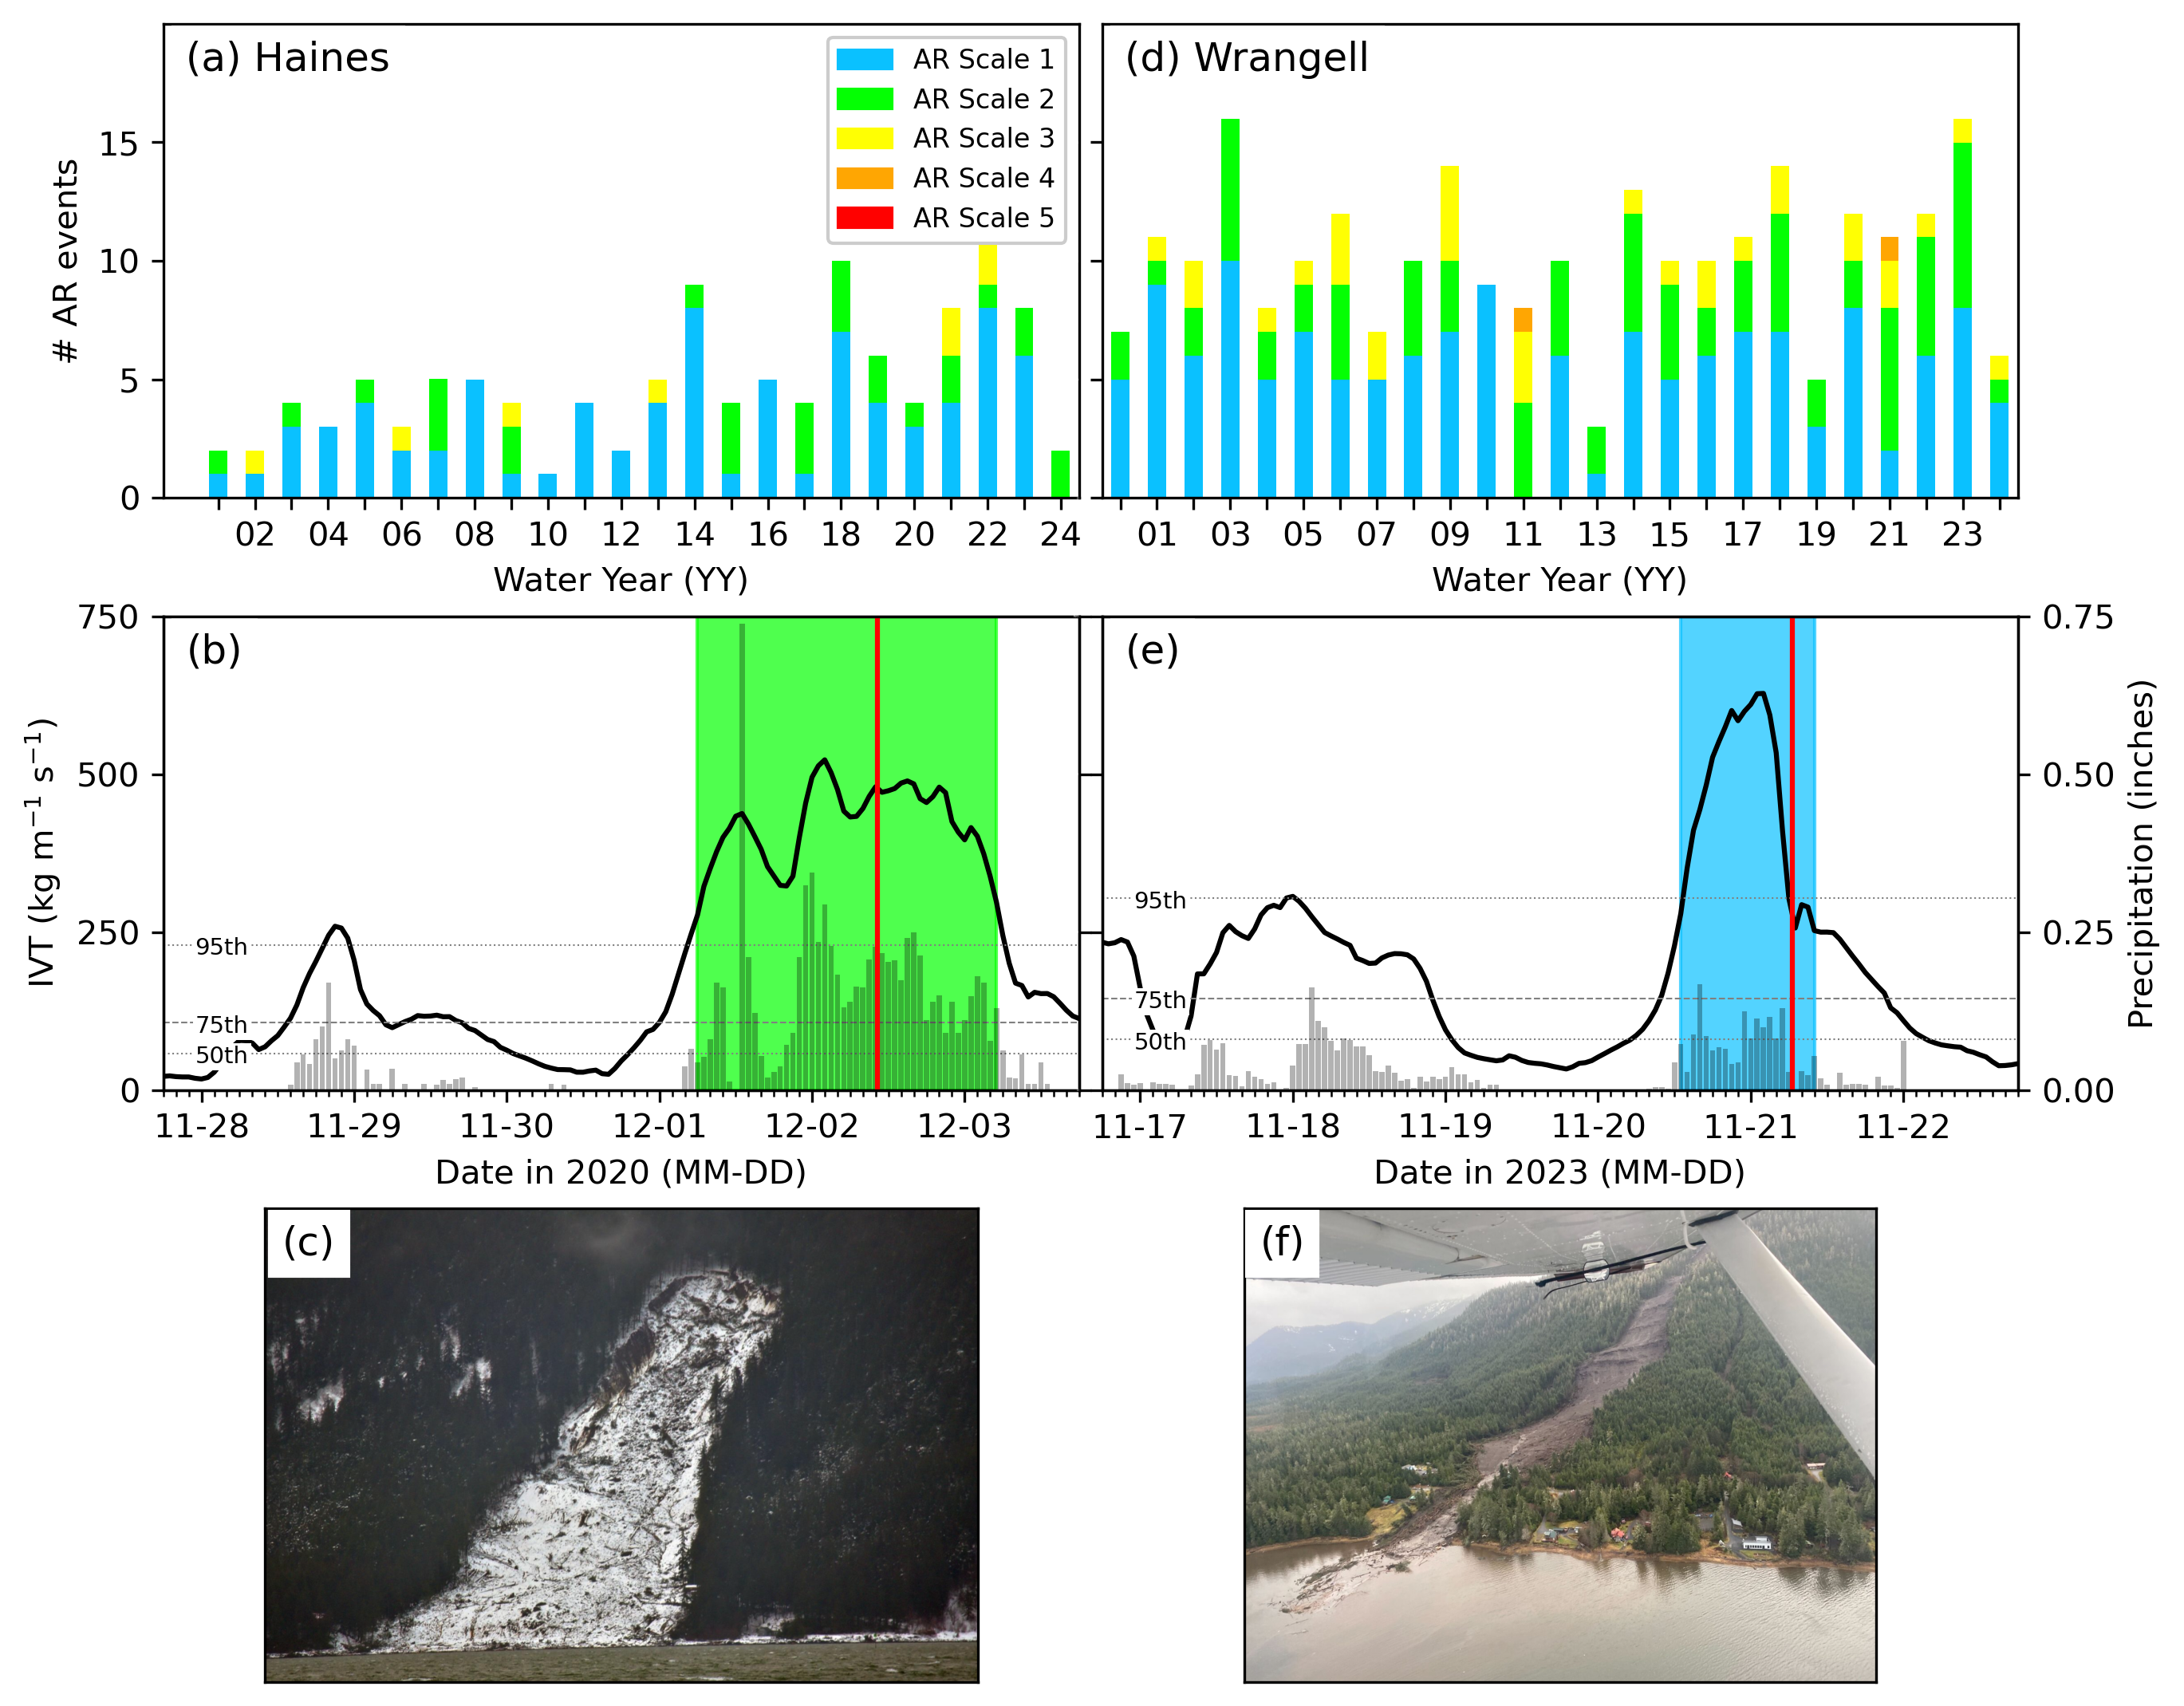

In [10]:
fname = '../figs/ar_tseries'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((10.0,9.0))
fig.dpi = 300

nrows = 3
ncols = 2

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1], width_ratios = [1, 1], wspace=0.025, hspace=0.25)
## use gs[rows index, columns index] to access grids

#####################################
### HISTORICAL AR SCALE FREQUENCY ###
#####################################

## haines
ax = fig.add_subplot(gs[0, 0])
ax = plot_historical_ar_scale_frequency(ax, df1, '(a) Haines')
plt.ylabel("# AR events")
ax.set_xlim(-1.5, 23.5)


### Legend
# create legend (of the 3 classes)
colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
patch0 = mpatches.Patch(color=colors[0], label='AR Scale 1')
patch1 = mpatches.Patch(color=colors[1], label='AR Scale 2')
patch2 = mpatches.Patch(color=colors[2], label='AR Scale 3')
patch3 = mpatches.Patch(color=colors[3], label='AR Scale 4')
patch4 = mpatches.Patch(color=colors[4], label='AR Scale 5')
ax.legend(handles=[patch0, patch1, patch2, patch3, patch4], 
          loc='upper right', framealpha=1.0, ncol=1, fontsize=8).set_zorder(200)

## wrangell
ax = fig.add_subplot(gs[0, 1])
ax = plot_historical_ar_scale_frequency(ax, df2, '(d) Wrangell')
plt.yticks(color='w', size=1) # hack: make the ytick labels white so the ticks show up but not the labels
ax.set_xlim(-0.5, 24.5)



#########################
### EVENT TIME SERIES ###
#########################

## haines
ax = fig.add_subplot(gs[1, 0])
plt.ylabel('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=10.)
plt.xlabel("Date in 2020 (MM-DD)")
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax = plot_IVT_time_series_AR_scale(ax, df_case1, df_arscale1, sublist1, d['haines']['landslide_time'], '(b)')


## add twin axis for prec
prec_df = read_mesowest_prec_data('../data/PAHN.csv') ## get prec data
prec = ax2.bar(x=prec_df.index, height=prec_df.values, width=0.035, color='k', alpha=0.3, align='center')
ax2.set_yticks(np.arange(0, 1, .25))
ax2.set_ylim(0, .75)
plt.yticks(color='w', size=1) # hack: make the ytick labels white so the ticks show up but not the labels

## wrangell
ax = fig.add_subplot(gs[1, 1])
plt.yticks(color='w', size=1) # hack: make the ytick labels white so the ticks show up but not the labels
plt.xlabel("Date in 2023 (MM-DD)")
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax = plot_IVT_time_series_AR_scale(ax, df_case2, df_arscale2, sublist2, d['wrangell']['landslide_time'], '(e)')

    
## add twin axis for prec
prec_df = read_mesowest_prec_data('../data/PAWG.csv') ## get prec data
ax2.set_ylabel('Precipitation (inches)', fontsize=10., color='k')
prec = ax2.bar(x=prec_df.index, height=prec_df.values, width=0.035, color='k', alpha=0.3, align='center')
ax2.set_yticks(np.arange(0, 1, .25))
ax2.set_ylim(0, .75)


##############
### PHOTOS ###
##############

### haines
ax = fig.add_subplot(gs[2, 0])
ax = plot_image(ax, '../data/landslide_haines2.png', '(c)')

### wrangell
ax = fig.add_subplot(gs[2, 1])
ax = plot_image(ax, '../data/landslide_wrangell2.jpg', '(f)')

fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()